# Exercise 2: AirBnB

## Project Workflow

#### Initial Questions
-) What is the best location to open up a new AirBnB?

The fist question we were trying to answer was how to predict the best location to open up a new AirBnB.
The first thing we did was to try and gather all the different data sets we had collected into a single one to be used for further analysis. To achieve this, our first approach was to try and calculate all the pairwise distances between the listings and points of interest. However, we quickly realized that we were lacking the computational power to do so. After doing some research on location analysis, we found out that the usual approach to circumvent this problem would be to use the count of points of interest in the same neighbourhood as the listing. Since the only kind of neighborhood available to us were the different districts of vienna, which are quite large and vary greatly in size, we decided to use an equally spaced grid of the city instead. Since we were going to do the analysis from the perspective of a new host, we needed to find some kind of measure for the revenue that would allow us to compare the different cells of the grid. For this purpose, we needed information about the rents/ buying prices for apartments as well as operating costs of AirBnBs. For the rents and prices, we found a data set from the city of vienna with the average rent/price per square meter per district, for the operating costs, no data sets were freely available. The next problem was that we could not really calculate the revenue, since we only knew the price per night per person of an AirBnB and had no information about the size of the apartments. Due to this, we had to alter the question, since we simply could not acquire the data that would have been necessary to answer the previous one.

Instead, we decided to focus on the other question which was about determining whether there was any connection between the location rating of an AirBnB and the different Points of Interest surrounding it. The plan was to first use statistical data analysis as well as a model that is easy to interpret for humans in order to analyse the effects that the different variables had on the location rating. Last but not least, we decided to try out several models to get an idea about whether any of them is able to find any connection between the features we were inspecting and the location rating of a listing.

#### Adjusted Questions
-) Is there any connection between the location of an AirBnb and Points of interests around it, to the location rating?
-) Is there a model that can detect any useful connection between the location rating and the points of interest in the area?

## Data sets

### listings.csv

Source: http://data.insideairbnb.com/austria/vienna/vienna/2022-09-11/data/listings.csv.gz

This dataset was downloaded from the Inside AirBnb webpage as a csv format. It contains information on 11797 unique listed AirBnb apartments/rooms located in Vienna on the 12th of October 2022.  The dataset is composed of 75 columns which include information on various properties of each listing, such as host, type of listing, its location, review ratings, capacities etc. Since the focus of our analysis was mostly on the  location of different AirBnb listings, this dataset was chosen as it contained the necessary information.

### LANDESGRENZEOGD.csv

Source: https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:LANDESGRENZEOGD&srsName=EPSG:4326&outputFormat=csv

This data set contains geolocation data about the borders of the Austrian federal states. This data set was chosen, to get the exact borders of Vienna. This was especially useful for plotting.

### HALTESTELLEWLOGD.csv
Source: https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:HALTESTELLEWLOGD&srsName=EPSG:4326&outputFormat=csv

This data set contains information about each of the public transport stations, in particular, the geolocation, name and an ID for each station. This data set was chosen, as the geolocation of each transport station is contained in it.

### WIENTOURISMUSOGD.csv
Source: https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&srsName=EPSG:4326&outputFormat=csv&typeName=ogdwien:WIENTOURISMUSOGD

This dataset contains information about 2797 points of interest for tourists. It is composed of 15 columns which include information on the location of each tourist point as well the category each tourist spot is classified to. This data set was chosen, as it is offers  information on a wide variety of different types of locations tourists might be interested in, such as restaurants, sights, theatres, parks, museums, etc.

### district_to_post.csv

Source: Handmade by authors of this project

This data set is basically just a mapping file, which provides a conversion between the postal code and the name of viennese district. This data set was created to join the listings.csv with the other data sets.

### rent_buy.csv
Source: https://www.immopreise.at/Wien/Wohnung/Miete
Handscrapped on 16/12/2022

This data set contains information about the average rent per square metre and average price per square metre of apartments in Vienna. This data set was chosen to provide information about expenses of an AirBnb apartment.

### model_data.csv
Source: Created by this Jupyternotebook

This data set was created out of the ones above and provides the data for the further analysis. It combines information from the AirBnB listings dataset with the different points of interest for tourists, the public transport stations as well as the average rent and buying prices for apartments. More specifically, for each listing, it includes the ID of the grid cell it is located in as well as the number of tourism spots, station and the average apartment prices/rents. Additional features from the InsideAirBnB were kept to describe the listing, such as the number of people it accommodates, the price per person per night, the room type and different kinds of review scores.


## Imports
The following libraries are used in this project. We also turned of the chained_assignment mode as this would cause problems, we avoid by reassigning the data sets instead of copying.

In [2]:
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapely.wkt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.prepared import prep

import statsmodels.formula.api as smf
import statsmodels.api as sm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.model_selection import train_test_split, RepeatedKFold,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,scale
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

pd.options.mode.chained_assignment = None

## Data preprocessing

### Listings

First we load the data set, then we remove the columns we do not need for our analysis. As shown below, the data set contains multiple columns containing information about the host, this is not needed for either of the target questions. Also, the information about the source, when it was scrapped or the url of the listings are dropped. The name and the description of the individual listing are not needed either, as this tasks focus mainly on price and location. Therefore, we only keep the columns that are related to price (`price` and `accommodates` as these will be needed to calculate the price per person) or to the location (`neighbourhood_cleansed` and the geolocation). The other columns that are kept either contain critical information to identify the listing (`ìd`) or provide additional information that might influence the price or the review of a location, without it being dependent on the host.

In [3]:
listings = pd.read_csv("data/listings.csv")
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [4]:
listings_cleaned = listings[["id", "neighbourhood_cleansed", "latitude", "longitude", "property_type",
                             "room_type", "accommodates", "price","number_of_reviews",
                             "review_scores_rating", "review_scores_location", "reviews_per_month"]]

In a next step we clean the `price` column of the $ sign, so we can later on cast it to numeric. Furthermore, we assign the correct data types to the columns.

In [5]:
listings_cleaned['price'] = listings_cleaned['price'].str.extract('(\d+)', expand=False)
listings_cleaned[['price']] = listings_cleaned[['price']].apply(pd.to_numeric)
listings_cleaned.astype({
    "id" : int, "neighbourhood_cleansed": 'category', "latitude": float, "longitude": float, "property_type": 'category',
                             "room_type": 'category', "accommodates": int, "number_of_reviews": int,
                             "review_scores_rating": float, "review_scores_location": float, "reviews_per_month": float
})
listings_cleaned.dtypes

id                          int64
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
property_type              object
room_type                  object
accommodates                int64
price                       int64
number_of_reviews           int64
review_scores_rating      float64
review_scores_location    float64
reviews_per_month         float64
dtype: object

Now we can identify all missing values

In [6]:
listings_cleaned.isna().sum()

id                           0
neighbourhood_cleansed       0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
price                        0
number_of_reviews            0
review_scores_rating      1928
review_scores_location    2024
reviews_per_month         1928
dtype: int64

The number of missing values in columns `review_scores_rating` and `reviews_per_month` suggest, that there is no rating, if there are no reviews, so we check if they are missing always in the same observations, having no reviews.

In [7]:
all(listings_cleaned['review_scores_rating'].isna() == listings_cleaned["reviews_per_month"].isna())

True

In [8]:
all(listings_cleaned['review_scores_rating'].isna() == (listings_cleaned['number_of_reviews'] == 0))

True

As we can see our assumptions is true, if we have no reviews we have a missing value, therefore the data for the two columns are missing at random. Now we first visualize the missing data on a grid, to see if there is some pattern. To do so we first need the `LANDESGRENZEOGD.csv` for the borders of Vienna. We read in the data set and create a Polygon object.

In [9]:
vienna_border = pd.read_csv("data/LANDESGRENZEOGD.csv")

def create_polygon(x):
    x['Polygon'] = shapely.wkt.loads(x['SHAPE'])
    return x

vienna_border = vienna_border.apply(lambda x: create_polygon(x), axis=1)
vienna_border.drop("SHAPE", inplace=True, axis=1)
vienna_border.head()

,FID,OBJECTID,NAME_LANDK,NAME_LANDG,NAME_GEMK,NAME_GEMG,STATAUSTRIA_LAND_KENN,STATAUSTRIA_GEM_KENN,STATAUSTRIA_BEZ_KENN,STATAUSTRIA_BEZ_CODE,FLAECHE,UMFANG,LU_DATE,SE_ANNO_CAD_DATA,Polygon
0,LANDESGRENZEOGD.10881,10881,Wien,WIEN,Stadt Wien,STADT WIEN,9,90001,900,900,4.148711e+08,136475.45,2022-08-26,NaN,POLYGON ((16.437761721115034 48.31681098205513...


As a next step we generate a grid to cover whole of Vienna, so we can more clearly see proximity of data points. This code chunk was heavily inspired by https://www.matecdev.com/posts/shapely-polygon-gridding.html.

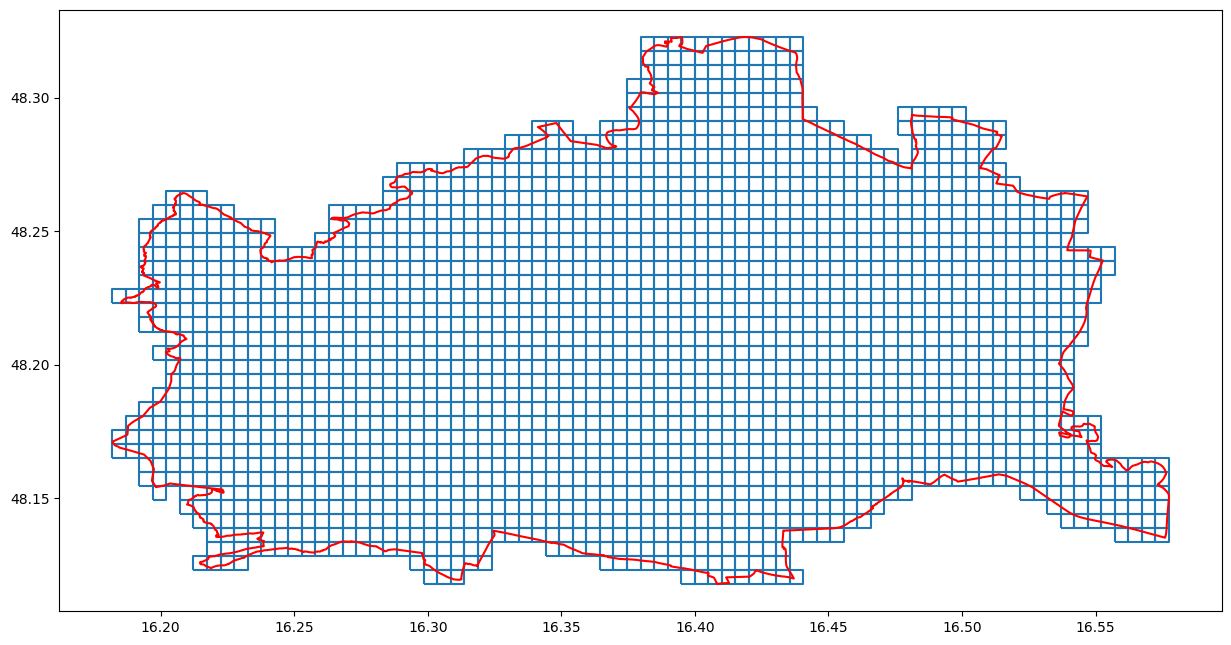

In [10]:
def grid_bounds(geom, delta):
    minx, miny, maxx, maxy = geom.bounds
    nx = int((maxx - minx) / delta)
    ny = int((maxy - miny) / delta)
    gx, gy = np.linspace(minx, maxx, nx), np.linspace(miny, maxy, ny)
    grid = []
    for i in range(len(gx) - 1):
        for j in range(len(gy) - 1):
            poly_ij = Polygon([[gx[i], gy[j]], [gx[i], gy[j + 1]], [gx[i + 1], gy[j + 1]], [gx[i + 1], gy[j]]])
            grid.append(poly_ij)
    return grid


def partition(geom, delta):
    prepared_geom = prep(geom)
    grid = list(filter(prepared_geom.intersects, grid_bounds(geom, delta)))
    return grid


geom = vienna_border.Polygon[0]
grid = partition(geom, 0.005)

fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(grid).boundary.plot(ax=ax)
gpd.GeoSeries([geom]).boundary.plot(ax=ax, color="red")
plt.show()

The plot is skewed a little bit, as the grid is defined by geolocation coordinates and the plot ignores the curvature of earth completely. This however does not change the fact, that each grid cell has same amount of square metres.

As a next step, we create a Point object out of the geolocation for each listing. Then we assign each listing the id of the grid cell it lies in. As this takes quite some time to calculate, we save the result in a new file, `grid_listings.csv`, and in a new data frame.

Information: The next code chunk takes quite a while to compute but should finish after about 10-20 minutes.

In [11]:
def create_point(x, from_shape=True, column1=None, column2=None):
    if from_shape:
        x['Point'] = shapely.wkt.loads(x['SHAPE'])
    else:
        x['Point'] = Point(x[column1], x[column2])
    return x

listings_cleaned = listings_cleaned.apply(
    lambda x: create_point(x, from_shape=False, column1='longitude', column2='latitude'), axis=1)

def inside_square(x, grid):
    point = x['Point']
    for sq_id, square in enumerate(grid):
        if square.contains(point):
            x['grid_id'] = sq_id
    return x


grid_listings = listings_cleaned.apply(lambda x: inside_square(x, grid), axis=1)

In [12]:
grid_listings.drop(['latitude', 'longitude'], axis=1, inplace=True)
grid_listings.to_csv("data/grid_listings.csv")
grid_listings.head()

,Point,accommodates,grid_id,id,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_location,review_scores_rating,reviews_per_month,room_type
0,POINT (16.42767 48.24262),3,1364.0,15883,Donaustadt,14,110,Room in bed and breakfast,4.71,4.71,0.15,Hotel room
1,POINT (16.37831 48.21924),5,976.0,38768,Leopoldstadt,350,69,Entire rental unit,4.75,4.75,2.50,Entire home/apt
2,POINT (16.32701 48.18434),6,665.0,40625,Rudolfsheim-Fnfhaus,181,145,Entire rental unit,4.59,4.83,1.23,Entire home/apt
3,POINT (16.37161 48.21496),2,943.0,392757,Innere Stadt,100,100,Entire rental unit,4.89,4.64,0.79,Entire home/apt
4,POINT (16.37847 48.21778),3,976.0,51287,Leopoldstadt,347,68,Entire rental unit,4.86,4.65,2.45,Entire home/apt


Now we have all the information we need to plot the listings on the map and marking the grid cells containing listings with missing values. To do so we first get all empty grid cells and the grid cells containing missing values, so we can plot them differently:

In [13]:
empty_sq = []
missing_review_sq = []
missing_loc_review_sq = []
grid_id_list = list(grid_listings['grid_id'])
grid_missing_review_id_list = list(grid_listings[grid_listings['number_of_reviews'] == 0]['grid_id'])
grid_missing_loc_review_id_list = list(grid_listings[grid_listings['review_scores_location'].isna()]['grid_id'])
for idx, sq in enumerate(grid):
    if idx not in grid_id_list:
        empty_sq.append(sq)
    if idx in grid_missing_review_id_list:
        missing_review_sq.append(sq)
    if idx in grid_missing_loc_review_id_list:
        missing_loc_review_sq.append(sq)

In the next code chunk we use that to plot the above selected cells on the map.

In [14]:
legend_elements = [Patch(facecolor='white', edgecolor='b',
                         label='No Listing'),
                   Patch(facecolor='darkgreen', edgecolor='b',
                         label='Listing without NA'),
                   Patch(facecolor='black', edgecolor='b',
                         label='Listing with no reviews'),
                   Patch(facecolor='yellow', edgecolor='b',
                         label='Listing with NA in review_scores_location')]

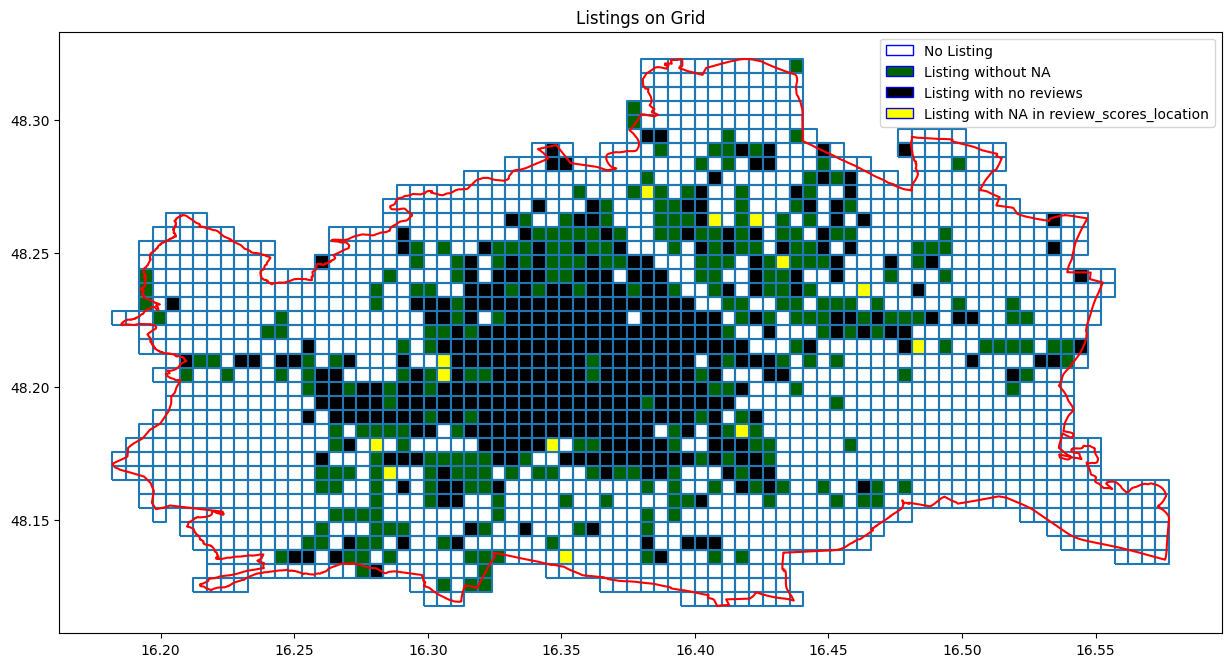

In [15]:
plot_grid = list(set(grid) - set(empty_sq))
fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(empty_sq).boundary.plot(ax=ax)
gpd.GeoSeries(plot_grid).boundary.plot(ax=ax, facecolor="darkgreen")
gpd.GeoSeries(missing_loc_review_sq).boundary.plot(ax=ax, facecolor="yellow")
gpd.GeoSeries(missing_review_sq).boundary.plot(ax=ax, facecolor="black")
gpd.GeoSeries([geom]).boundary.plot(ax=ax, color="red")
ax.legend(handles=legend_elements)
plt.title("Listings on Grid")
plt.show()

This map shows that there is no real pattern for listings not having any reviews. But it seems like most of the `review_scores_location` missing values are due to the number of reviews being zero. So we check this assumption:


In [16]:
len(grid_listings[(grid_listings['number_of_reviews']!=0) & (grid_listings['review_scores_location'].isna())])

96

As we can see only 96 observations have missing values, if there are reviews available. We assume that these are MAR as well, as some people did not rate the location, but left an overall review score. Therefore, as dropping the observations would lose us about a fifth of the available listings and we suspect the data is MAR, we use MICE instead to impute the missing values.

In [17]:
df_mice = grid_listings.filter(['accommodates', 'grid_id', 'id',  'number_of_reviews',
                                'price',  'review_scores_location', 'review_scores_rating','reviews_per_month'], axis=1).copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)
grid_listings[['review_scores_location', 'review_scores_rating', 'reviews_per_month']] = df_mice_imputed[['review_scores_location', 'review_scores_rating', 'reviews_per_month']]

In [18]:
grid_listings.isna().sum()

Point                      0
accommodates               0
grid_id                   70
id                         0
neighbourhood_cleansed     0
number_of_reviews          0
price                      0
property_type              0
review_scores_location     0
review_scores_rating       0
reviews_per_month          0
room_type                  0
dtype: int64

Above we can see that we have 70 listings that have no `grid_id`, first we check if those are actually the ones outside of Vienna, we do that by plotting again.

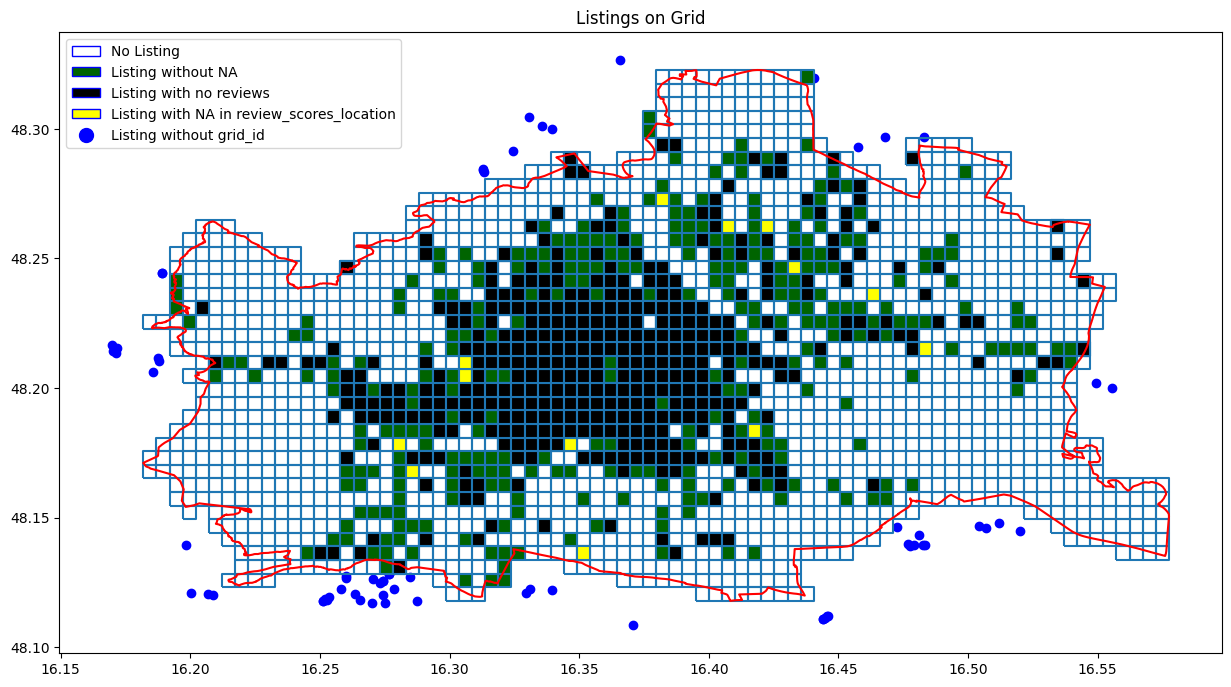

In [19]:
legend_elements = [Patch(facecolor='white', edgecolor='b',
                         label='No Listing'),
                   Patch(facecolor='darkgreen', edgecolor='b',
                         label='Listing without NA'),
                   Patch(facecolor='black', edgecolor='b',
                         label='Listing with no reviews'),
                   Patch(facecolor='yellow', edgecolor='b',
                         label='Listing with NA in review_scores_location'),
                   Line2D([0], [0], marker='o', color='blue', label='Listing without grid_id',
                      markerfacecolor='blue', markersize=10, ls = '')]
possibly_outside = grid_listings.copy()
possibly_outside.isna().sum()
possibly_outside_points = possibly_outside[possibly_outside['grid_id'].isna()]
plot_grid = list(set(grid) - set(empty_sq))
fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(empty_sq).boundary.plot(ax=ax)
gpd.GeoSeries(plot_grid).boundary.plot(ax=ax, facecolor="darkgreen")
gpd.GeoSeries(missing_loc_review_sq).boundary.plot(ax=ax, facecolor="yellow")
gpd.GeoSeries(missing_review_sq).boundary.plot(ax=ax, facecolor="black")
gpd.GeoSeries(possibly_outside_points['Point']).plot(ax=ax, color="blue")
gpd.GeoSeries([geom]).boundary.plot(ax=ax, color="red")
ax.legend(handles=legend_elements)
plt.title("Listings on Grid")
plt.show()

It is clearly visible, that all those listings are outside of Vienna, as the scope of the project is defined by looking at listings in Vienna, we remove those from the `grid_listings`

In [20]:
grid_listings=grid_listings.dropna()
grid_listings.isna().sum()

Point                     0
accommodates              0
grid_id                   0
id                        0
neighbourhood_cleansed    0
number_of_reviews         0
price                     0
property_type             0
review_scores_location    0
review_scores_rating      0
reviews_per_month         0
room_type                 0
dtype: int64

Now we have cleaned the `grid_listings`. As the price is not really comparable due to different sizes of appartements/rooms, we try to make it more comparable by introducing a new column: `price_per_person`. This way appartements/rooms for more than one person do not have a significantly higher price per default than single person appartements/rooms.

In [21]:
grid_listings['price_per_person'] = grid_listings['price']/grid_listings['accommodates']

We take a look whether this generated any NAs.

In [22]:
grid_listings.isna().sum()

Point                     0
accommodates              0
grid_id                   0
id                        0
neighbourhood_cleansed    0
number_of_reviews         0
price                     0
property_type             0
review_scores_location    0
review_scores_rating      0
reviews_per_month         0
room_type                 0
price_per_person          1
dtype: int64

As this is only one observation, we decided to drop it.

In [23]:
grid_listings.dropna(inplace=True)

As a next step, we want to get the information form the `neighbourhood_cleansed` column, the district of Vienna, into a more convenient format, so it is compatible with the other data sets. For this we first need to fix problems with German Umlaute, to be exact, the district `Rudolfsheim-Fünfhaus`, was not correctly loaded. Therefore, we replace every row containing `Rudolfsheim`, with the correct `Rudolfsheim-Fünfhaus`. Then we use the `district_to_post.csv`, to get the postal code for each district. Now we can drop the merge columns, `neighbourhood_cleansed` from `grid_listings` and `name` from `district_to_post`.

In [24]:
grid_listings.loc[:, 'neighbourhood_cleansed'] = grid_listings.loc[:, 'neighbourhood_cleansed'].apply(
    lambda x: "Rudolfsheim-Fünfhaus" if str(x).__contains__("Rudolfsheim") else x
)
mapping = pd.read_csv("data/district_to_post.csv")
merged = grid_listings.merge(mapping, left_on="neighbourhood_cleansed", right_on="name", how="inner")
merged.head()
merged.drop(["neighbourhood_cleansed", "name"], inplace=True, axis=1)
merged.rename({"name_x": "name"}, inplace=True, axis=1)
grid_listings = merged
grid_listings.head()

,Point,accommodates,grid_id,id,number_of_reviews,price,property_type,review_scores_location,review_scores_rating,reviews_per_month,room_type,price_per_person,post
0,POINT (16.42767 48.24262),3,1364.0,15883,14,110,Room in bed and breakfast,4.71,4.71,0.15,Hotel room,36.666667,1220
1,POINT (16.42418 48.23796),4,1324.0,813826,10,82,Entire rental unit,5.00,4.80,0.10,Entire home/apt,20.500000,1220
2,POINT (16.41152 48.23549),3,1246.0,846009,72,60,Entire condo,4.86,4.77,0.61,Entire home/apt,20.000000,1220
3,POINT (16.44955 48.22707),2,1504.0,1384870,92,34,Private room in rental unit,4.59,4.60,0.83,Private room,17.000000,1220
4,POINT (16.51765 48.21659),4,1876.0,3217556,17,76,Entire rental unit,4.65,4.76,0.51,Entire home/apt,19.000000,1220


As the `grid_listings` now has the desired format, we can write it again.

In [25]:
grid_listings.to_csv("data/grid_listings_cleaned.csv")

### Stations

Again we load the data set and create a column with Point objects, so we can determine in which grid cell the public transport station is. Here we use the functions from above to receive the intended result.

Information: The next chunk might take a couple of minutes to compute.

In [26]:
stations = pd.read_csv("data/HALTESTELLEWLOGD.csv")
stations = stations.apply(lambda x: create_point(x), axis=1)
stations.drop("SHAPE", inplace=True, axis=1)
grid_stations = stations.apply(lambda x: inside_square(x, grid), axis=1)
grid_stations.head()

,BEZEICHNUNG,FID,OBJECTID,Point,SE_ANNO_CAD_DATA,WL_NUMMER,grid_id
0,Absberggasse,HALTESTELLEWLOGD.1,1,POINT (16.389770011932953 48.17379006621729),NaN,1,1040.0
1,Achengasse,HALTESTELLEWLOGD.2,2,POINT (16.448900012566884 48.2845300657776),NaN,2,1515.0
2,Ada-Christen-Gasse,HALTESTELLEWLOGD.3,3,POINT (16.38581001194899 48.15293006544885),NaN,3,1036.0
3,Adam-Betz-Gasse,HALTESTELLEWLOGD.4,4,POINT (16.535120013111975 48.21564006599573),NaN,4,1944.0
4,Adamovichgasse,HALTESTELLEWLOGD.5,5,POINT (16.337990012520667 48.142290065576454),NaN,5,714.0


The goal with this data set is, that we count the number of transport stations per grid cell, therefore we can drop everything except the `OBJECTID`,`grid_id` and `Point` (which we can use for plotting purposes).

In [27]:
grid_stations = grid_stations[['OBJECTID', 'grid_id', 'Point']]

Now we check whether the data contains NAs or not.

In [28]:
grid_stations.isna().sum()

OBJECTID    0
grid_id     2
Point       0
dtype: int64

We check again whether those two stations are outside of Vienna or not.

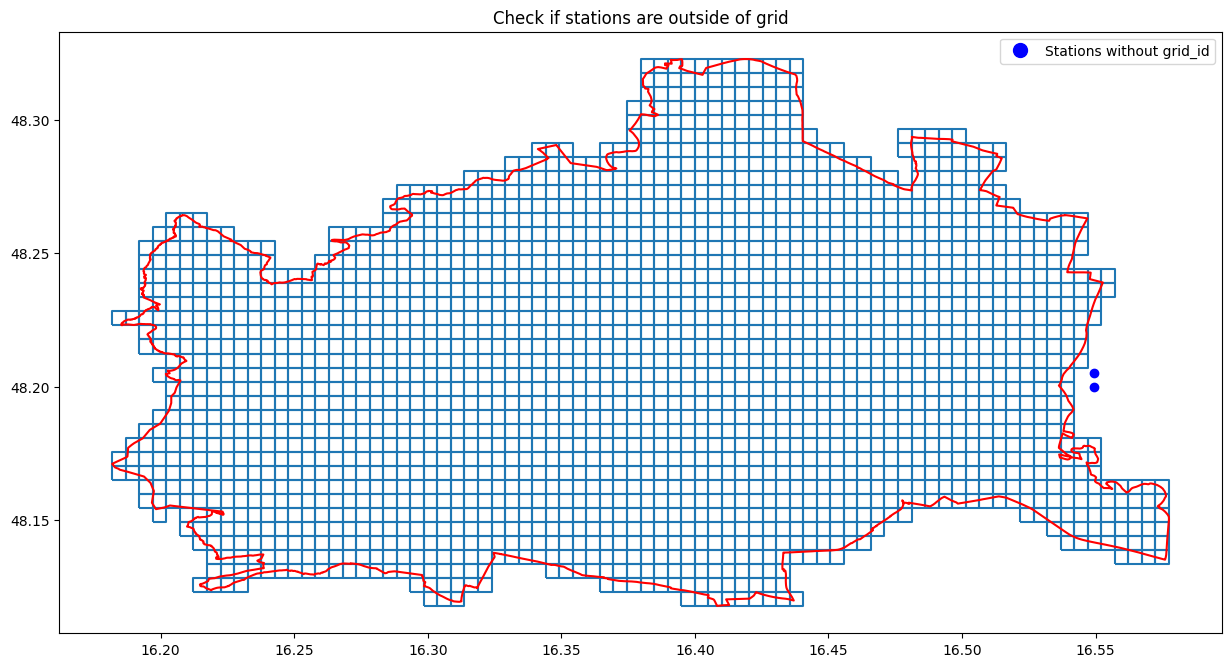

In [29]:
legend_elements = [Line2D([0], [0], marker='o', color='blue', label='Stations without grid_id',
                      markerfacecolor='blue', markersize=10, ls = '')]
possibly_outside = grid_stations.copy()
possibly_outside_points = possibly_outside[possibly_outside['grid_id'].isna()]
fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(grid).boundary.plot(ax=ax)
gpd.GeoSeries(possibly_outside_points['Point']).plot(ax=ax, color="blue")
gpd.GeoSeries([geom]).boundary.plot(ax=ax, color="red")
ax.legend(handles=legend_elements)
plt.title("Check if stations are outside of grid")
plt.show()

Again our assumption holds true, that those without `grid_id` are outside of Vienna, therefore we can drop them.

In [30]:
grid_stations.dropna(inplace=True)
grid_stations.isna().sum()

OBJECTID    0
grid_id     0
Point       0
dtype: int64

Now we have cleaned the `grid_stations`. We want to use the number of stations per grid cell as information, so we aggregate this first.

In [31]:
model_data_stations = grid_stations.groupby("grid_id").agg(
    number_st=("grid_id", "count"))
model_data_stations.head()

,number_st
grid_id,
29.0,1
33.0,1
52.0,1
53.0,1
71.0,1


### WIENTOURISMUSOGD.csv

We only select the relevant columns out of the data set, and we remove everything related to accommodations, meaning hotels, pensions, appartements and seasonal hotels. We do this, because we assume, that tourists are not interested in visiting hotels, when staying in an AirBnb. We are aware that this assumption does not always hold (for example Hotel Sacher is a point of interest for tourists), but in general this is true.

In [32]:
tourism = pd.read_csv("data/WIENTOURISMUSOGD.csv")
toursim_cleaned = tourism[['NAME','POSTALCODE', 'CATEGORY_NAME','SUBCATEGORY_NAME', 'GEOLAT', 'GEOLONG']]
remove_cats = ['Hotel', 'Pension', 'Appartement', 'Saisonhotel']
toursim_cleaned = toursim_cleaned[~toursim_cleaned['SUBCATEGORY_NAME'].isin(remove_cats)]
toursim_cleaned.head()

,NAME,POSTALCODE,CATEGORY_NAME,SUBCATEGORY_NAME,GEOLAT,GEOLONG
0,Porzellan,1090,"Essen, Trinken & Nightlife",Restaurant,48.219222,16.364447
1,Postamt 1150 Wien,1150,Infrastruktur,Sonstiges,48.195808,16.338125
2,Prater Alm,1020,"Essen, Trinken & Nightlife",Gasthaus & Beisl,48.215450,16.402072
3,Pratermuseum,1020,Sightseeing,Museum,48.216236,16.394952
4,Praterturm,1020,Sightseeing,Sehenswürdigkeit,48.216727,16.398029


The next step, as already with the other data sets, is creating a `Point` column and checking within which grid cell each of the data points lies.

Information: The next chunk may take a couple of minutes to compute.

In [33]:
toursim_cleaned = toursim_cleaned.apply(lambda x: create_point(x, from_shape=False, column1='GEOLONG', column2='GEOLAT'), axis=1)
grid_tourism = toursim_cleaned.apply(lambda x: inside_square(x, grid), axis=1)
grid_tourism.head()

,NAME,POSTALCODE,CATEGORY_NAME,SUBCATEGORY_NAME,GEOLAT,GEOLONG,Point,grid_id
0,Porzellan,1090,"Essen, Trinken & Nightlife",Restaurant,48.219222,16.364447,POINT (16.3644467 48.2192221),881
1,Postamt 1150 Wien,1150,Infrastruktur,Sonstiges,48.195808,16.338125,POINT (16.3381246 48.195808),724
2,Prater Alm,1020,"Essen, Trinken & Nightlife",Gasthaus & Beisl,48.215450,16.402072,POINT (16.4020719 48.2154501),1164
3,Pratermuseum,1020,Sightseeing,Museum,48.216236,16.394952,POINT (16.3949522 48.2162356),1125
4,Praterturm,1020,Sightseeing,Sehenswürdigkeit,48.216727,16.398029,POINT (16.3980286 48.2167269),1125


Now we check for NAs in this data set.

In [34]:
grid_tourism.isna().sum()

NAME                0
POSTALCODE          0
CATEGORY_NAME       0
SUBCATEGORY_NAME    0
GEOLAT              0
GEOLONG             0
Point               0
grid_id             0
dtype: int64

As we can see there are no NA values, so we can prepare the data set in the way we want. So we aggregate the number of observations per grid cell, as well as the number of unique subcategories per grid cell. We introduced this column, since we thought that it might make a difference to tourists whether all of the points of interest around their accommodation are similar or there are various kinds.

In [35]:
model_data_tsm = grid_tourism.groupby("grid_id").agg(
    number_different_tsm=("SUBCATEGORY_NAME", "nunique"),
    number_tsm=("grid_id", "count"))
model_data_tsm.head()

,number_different_tsm,number_tsm
grid_id,,
33,1,2
53,1,1
125,2,2
176,1,1
234,1,1


Now we can continue with merging the data sets.

### Merging the data sets

First we use the `rent_buy.csv` to add rental and buying information to each listing. We can do this without checking the `rent_buy.csv` for clean data, as we generated the data per hand and know it is clean.

In [36]:
rent_buy = pd.read_csv("data/rent_buy.csv")
grid_listings = grid_listings.merge(rent_buy, on='post', how="left")

As a next step, we merge the three data sets and save it to `model_data.csv`.

In [37]:
model_data = grid_listings.merge(model_data_tsm, on="grid_id").merge(model_data_stations, on="grid_id")
model_data.reset_index(inplace=True)
model_data.to_csv("data/model_data.csv", index=False)
model_data.head()

,index,Point,accommodates,grid_id,id,number_of_reviews,price,property_type,review_scores_location,review_scores_rating,reviews_per_month,room_type,price_per_person,post,avg_rent,avg_buy,number_different_tsm,number_tsm,number_st
0,0,POINT (16.42767 48.24262),3,1364.0,15883,14,110,Room in bed and breakfast,4.71,4.71,0.15,Hotel room,36.666667,1220,16.72,6668.69,3,3,1
1,1,POINT (16.42773 48.24256),3,1364.0,12634008,1,110,Room in bed and breakfast,5.00,5.00,0.45,Hotel room,36.666667,1220,16.72,6668.69,3,3,1
2,2,POINT (16.42952 48.23869),3,1364.0,19281153,74,120,Entire rental unit,4.88,4.89,1.19,Entire home/apt,40.000000,1220,16.72,6668.69,3,3,1
3,3,POINT (16.42418 48.23796),4,1324.0,813826,10,82,Entire rental unit,5.00,4.80,0.10,Entire home/apt,20.500000,1220,16.72,6668.69,5,5,2
4,4,POINT (16.42339 48.23837),2,1324.0,4134543,2,40,Entire rental unit,4.50,5.00,0.02,Entire home/apt,20.000000,1220,16.72,6668.69,5,5,2


## Relationship between location rating and collected features

In the next section, we focus on extracting whether our collected data, mainly, the number of tourism spots, the number of unique tourism spots, the average rent, as well as the average buy price and the number of transport stations within a grid effect the locations rating and if so in which way.

The first approach here is taking a look at the correlation:

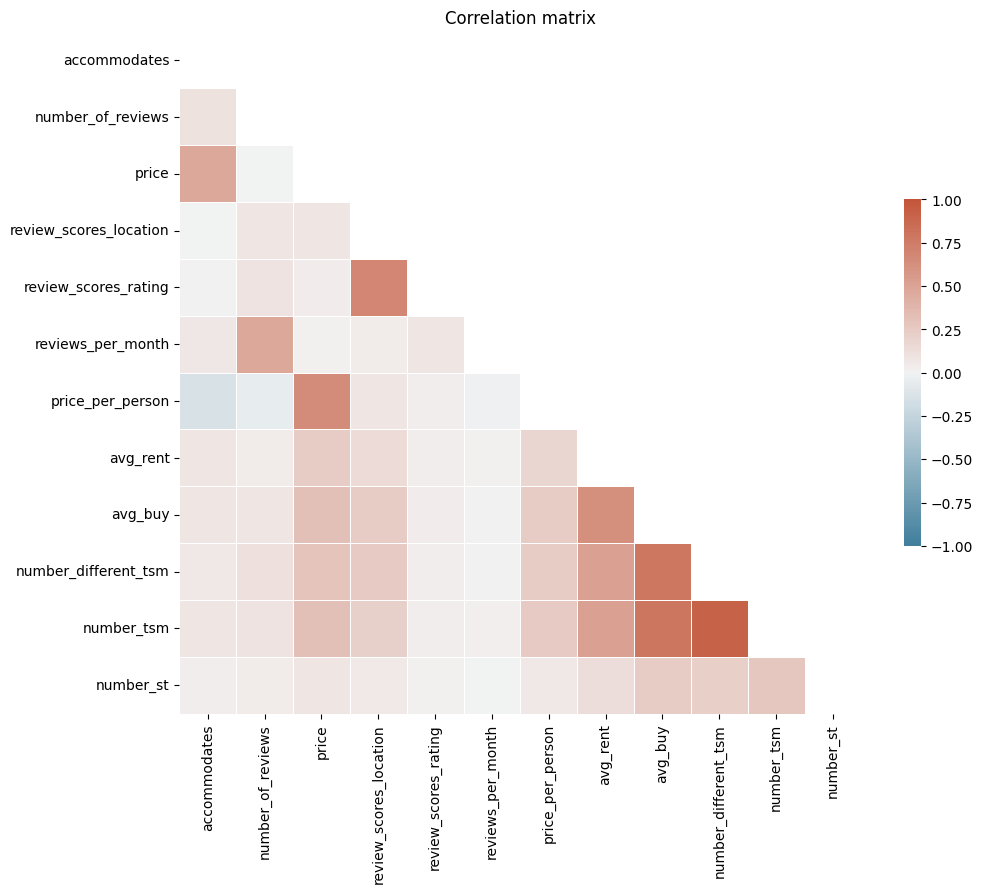

In [38]:
model_data = pd.read_csv('data/model_data.csv')

relevant_features_df = model_data.drop(['index', 'Point', 'id', 'post', 'grid_id'], axis=1)
corr = relevant_features_df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation matrix")
plt.show()

The column of interest is `review_scores_location`, which does not correlate with any of the columns, except `review_scores_rating`, which is to be expected. If one rates the location with a high score, the overall score is most likely being higher as well.
As correlation only tells us something about the linear relationship, we will take a look at the scatterplot matrix as well.

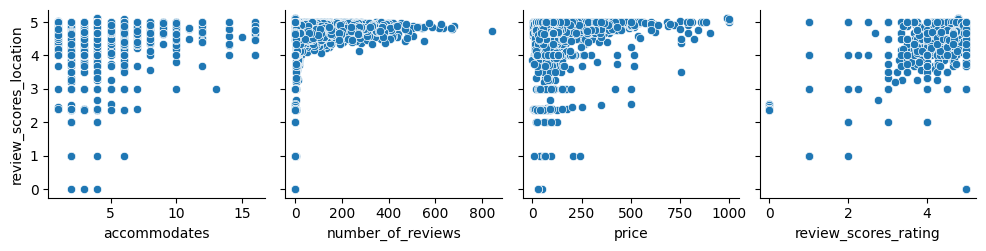

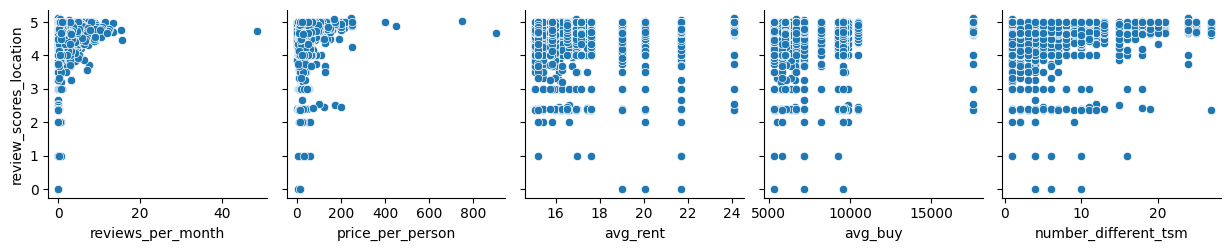

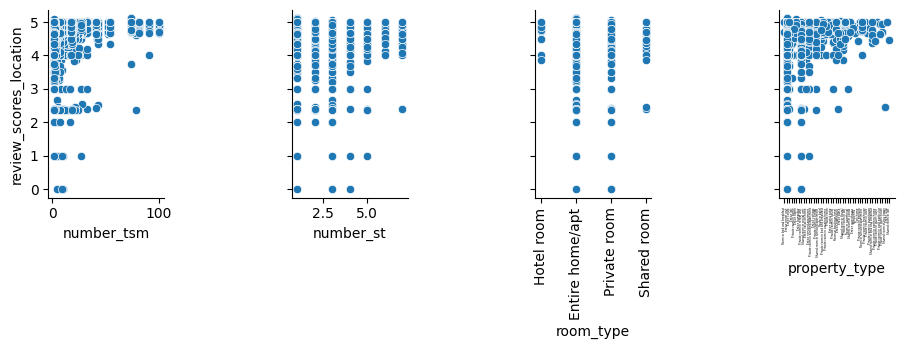

In [39]:
sns.pairplot(relevant_features_df, y_vars=['review_scores_location'], x_vars=['accommodates', 'number_of_reviews', 'price', 'review_scores_rating'])
sns.pairplot(relevant_features_df, y_vars=['review_scores_location'], x_vars=['reviews_per_month', 'price_per_person', 'avg_rent', 'avg_buy', 'number_different_tsm'])
grid = sns.pairplot(relevant_features_df, y_vars=['review_scores_location'], x_vars=['number_tsm', 'number_st', 'room_type', 'property_type'])
grid.axes.flat[2].tick_params(axis='x', labelrotation=90)
grid.axes.flat[3].tick_params(axis='x', labelrotation=90, labelsize=2)

The `property_type` has not well readable x-ticks, but this is ignored, as if there would be a pattern visible, we would have taken a closer look at it. In all these plots no clear pattern or relationship between the variables is visible, therefore we will now take a look at the histograms of these variables.

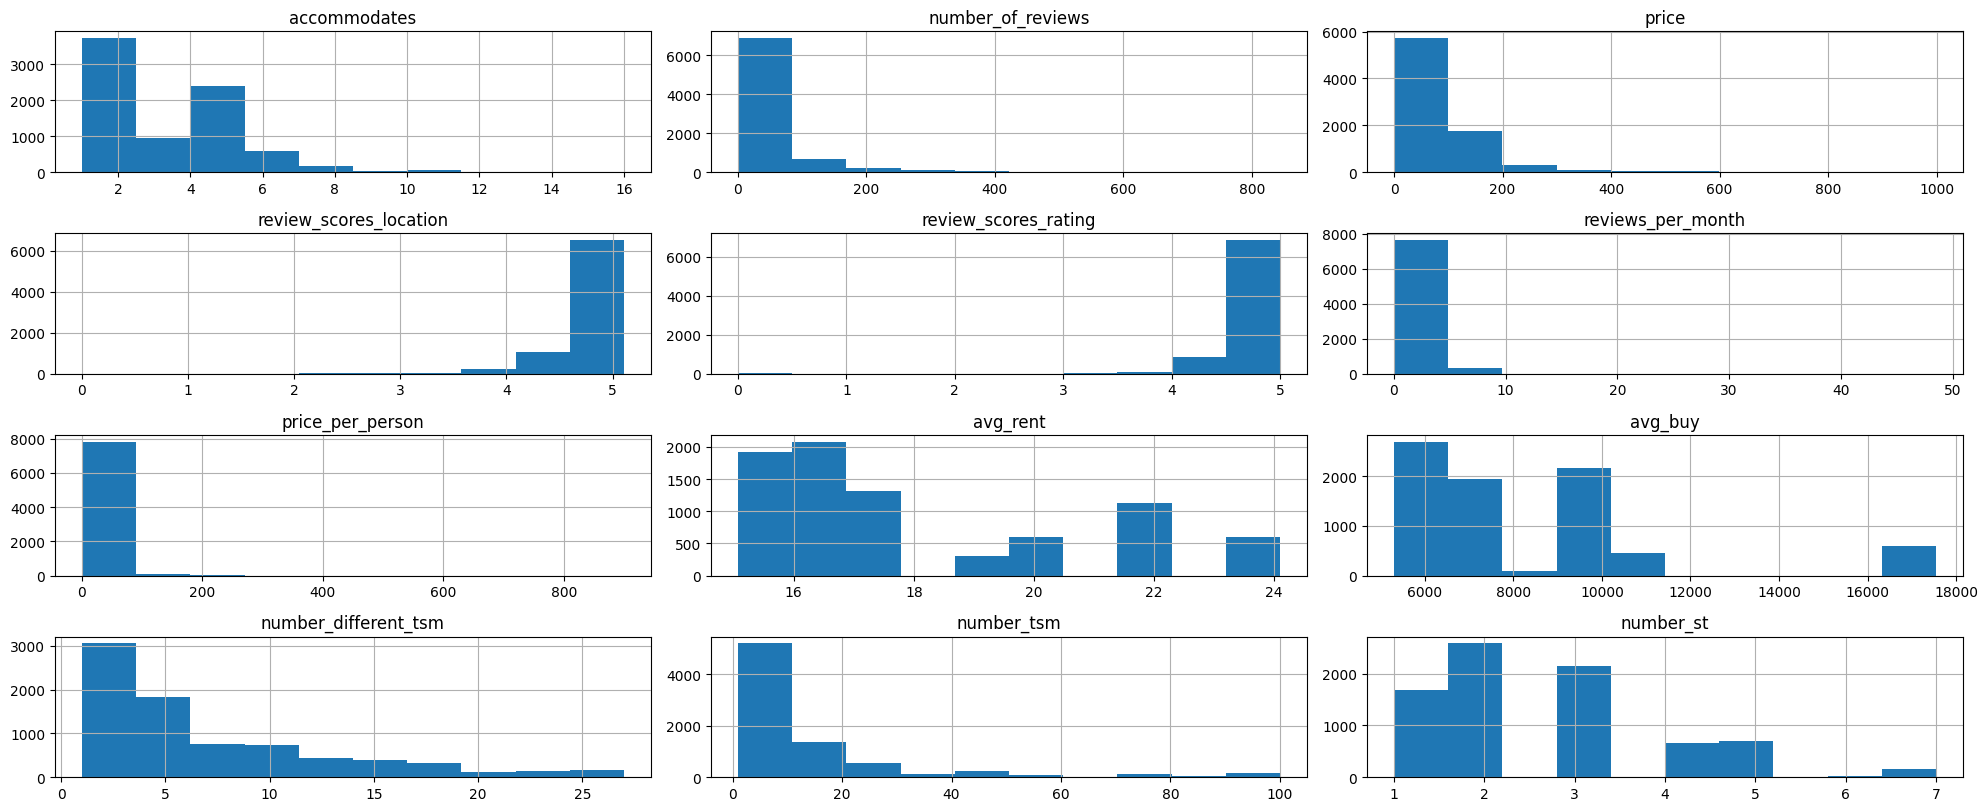

In [40]:
ax_list = relevant_features_df.hist(layout=(5,3), figsize=(20,10))
plt.tight_layout()

Now we take the a closer look at all the right or left skewed features, so we can log transform them, in the hope to get a more linear relationship with the `review_scores_location` variable.

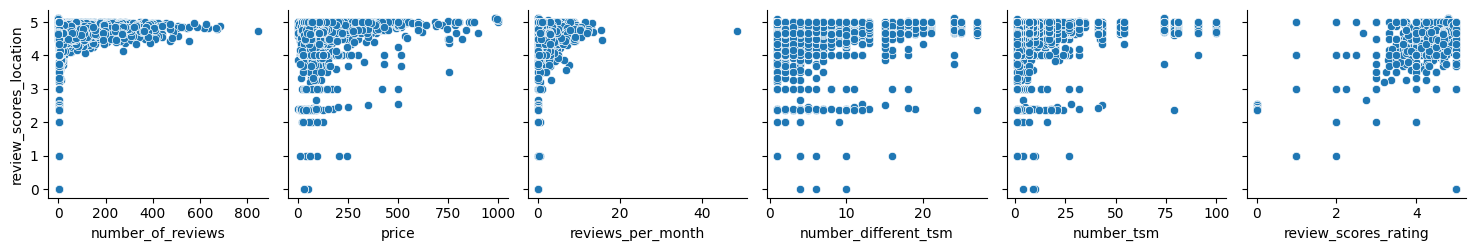

In [41]:
log_df = relevant_features_df[['review_scores_location', 'number_of_reviews', 'price', 'reviews_per_month', 'number_different_tsm', 'number_tsm', 'review_scores_rating']]
log_df = log_df.apply(np.log, axis=1)
log_df.review_scores_location = relevant_features_df.review_scores_location
sns.pairplot(relevant_features_df, y_vars=['review_scores_location'], x_vars=['number_of_reviews', 'price', 'reviews_per_month', 'number_different_tsm', 'number_tsm', 'review_scores_rating'])
plt.show()

After this data exploration, we fit a OLS to describe the relationship. The reason for choosing this very simple model is, that it is easily interpretable for humans and gives us information about the influence of each variable via the estimated coefficient. We are using the `stats` version of it, as it allows a summary, that automatically performs significance tests, which give information whether to drop a variable for the model or not. We will use the 5\% significance level for dropping variables.

In [42]:
model = smf.ols(formula="review_scores_location ~ np.log(number_of_reviews, where=(number_of_reviews!=0)) +"
                        "np.log(price, where=(price!=0)) + "
                        "np.log(reviews_per_month) + np.log(number_different_tsm) +"
                        "np.log(number_tsm) + np.log(review_scores_rating, where=(review_scores_rating!=0)) + C(room_type) + "
                        "C(property_type) + number_st + avg_buy + avg_rent +"
                        "accommodates", data=relevant_features_df).fit()

print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     review_scores_location   R-squared:                       0.160
Model:                                OLS   Adj. R-squared:                  0.154
Method:                     Least Squares   F-statistic:                     27.33
Date:                    Sun, 22 Jan 2023   Prob (F-statistic):          1.27e-252
Time:                            10:19:52   Log-Likelihood:                -2790.8
No. Observations:                    7970   AIC:                             5694.
Df Residuals:                        7914   BIC:                             6085.
Df Model:                              55                                         
Covariance Type:                nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

The adjusted R-squared is really low of the model, therefore we try it without the log transformation.

In [43]:
model = smf.ols(formula="review_scores_location ~ number_of_reviews +"
                        "price + "
                        "reviews_per_month + number_different_tsm +"
                        "number_tsm + review_scores_rating + C(room_type) + "
                        "C(property_type) + number_st + avg_buy + avg_rent +"
                        "accommodates", data=relevant_features_df).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     review_scores_location   R-squared:                       0.529
Model:                                OLS   Adj. R-squared:                  0.525
Method:                     Least Squares   F-statistic:                     161.3
Date:                    Sun, 22 Jan 2023   Prob (F-statistic):               0.00
Time:                            10:19:53   Log-Likelihood:                -487.37
No. Observations:                    7970   AIC:                             1087.
Df Residuals:                        7914   BIC:                             1478.
Df Model:                              55                                         
Covariance Type:                nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

We can see that the model has now a much higher adjusted R-squared. As all the categorical variables (`room_type` and `property_type`) are really insignificant we drop those.

In [44]:
model = smf.ols(formula="review_scores_location ~ number_of_reviews +"
                        "price + "
                        "reviews_per_month + number_different_tsm +"
                        "number_tsm + review_scores_rating  + "
                        "number_st + avg_buy + avg_rent +"
                        "accommodates", data=relevant_features_df).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     review_scores_location   R-squared:                       0.526
Model:                                OLS   Adj. R-squared:                  0.525
Method:                     Least Squares   F-statistic:                     882.1
Date:                    Sun, 22 Jan 2023   Prob (F-statistic):               0.00
Time:                            10:19:53   Log-Likelihood:                -511.33
No. Observations:                    7970   AIC:                             1045.
Df Residuals:                        7959   BIC:                             1121.
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

This dramatically decreased our model size, but the adj. R-squared is still the same. Now we drop the other insignificant variables:

In [45]:
model = smf.ols(formula="review_scores_location ~ "
                        "number_different_tsm +"
                        "number_tsm + review_scores_rating  + "
                        "avg_buy + avg_rent +"
                        "accommodates", data=relevant_features_df).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     review_scores_location   R-squared:                       0.526
Model:                                OLS   Adj. R-squared:                  0.525
Method:                     Least Squares   F-statistic:                     1471.
Date:                    Sun, 22 Jan 2023   Prob (F-statistic):               0.00
Time:                            10:19:53   Log-Likelihood:                -511.78
No. Observations:                    7970   AIC:                             1038.
Df Residuals:                        7963   BIC:                             1086.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

After dropping all the insignificant variables, we have received a small model that has the same adjusted R-squared as the biggest one. Now we check whether the model assumptions are even fulfilled.

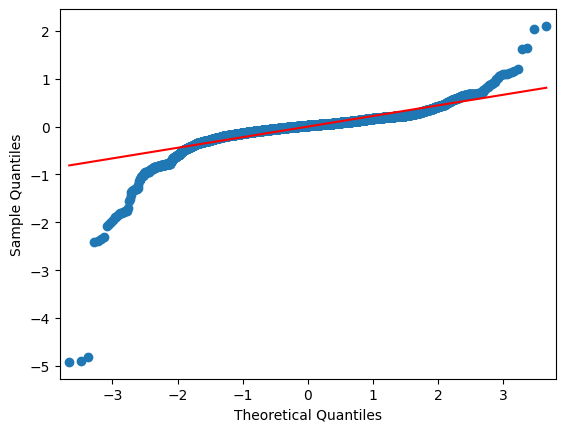

In [46]:
qq = sm.qqplot(model.resid, line='r')

The qq-plot does not look too great, as the sample distribution seems to have heavier tails than the normal distribution it is compared against. There are three points, that we need to check, because those are obviously outliers and we want to know whether they impact the model a lot.

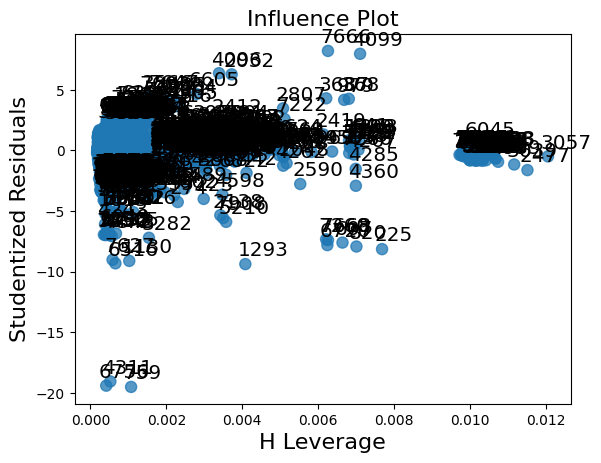

In [47]:
levfig = sm.graphics.influence_plot(model, size=8)

Using the influence plot, we can see that the three outliers before (those with really low studentized residuals) have close to zero impact on our model, so we can just leave them in. Now we can interpret the model:

Obviously, the most important factor that impacts the `review_scores_location` is the `review_scores_rating`, while the other ones have comparatively little impact, most of them even with negative coefficients. Interestingly enough, the number of different tourism points of interest has a positive impact, while the overall number of tourism points of interest has a negative one. The intercept is close to 2.5, which is what one would expect, the high `review_scores_location` are explained by the overall high ratings.

This concludes the answer to the question on how much impact points of interest and additional factors have on the location rating of an AirBnb.

## Model Performance Comparison
The original goal was to predict the best location for a new AirBnb, if you are a host. One of the major factors is the expenses for an AirBnb at a certain location, this information sadly was not available. While one could get the average rent and buying prices per square metre, no information about typical sizes of AirBnbs in square metres per type (or number of accommodates) were available for free. Neither were typical operating costs per district (or more precise) available. Therefore, we followed the data science cycle and went back and looked for questions we could answer with all the data we were able to collect (and was generally available for free). For more details, you can look at the description of how our research questions changed at the beginning of this notebook.

In this next section, we attempt to fit the best model to predict the location rating that does not use any information about the corresponding AirBnB. This includes the average rent and average buying price per square meter, the number of different tourism spots, the overall count of tourism spots and the number of public transport stations per grid. The reason for this approach is that we want to confirm that it is not only the choice of a simple linear regression model that caused the very poor performance and results on this dat set.

In [48]:
model_data_agg = model_data[["grid_id","review_scores_location","avg_rent","avg_buy","number_different_tsm","number_tsm","number_st"]]\
    .groupby(by = "grid_id").mean("review_scores_location").reset_index()

model_data_agg

,grid_id,review_scores_location,avg_rent,avg_buy,number_different_tsm,number_tsm,number_st
0,53.0,5.078390,16.940000,6646.130000,1.0,1.0,1.0
1,176.0,4.678941,16.940000,6646.130000,1.0,1.0,1.0
2,234.0,4.000000,17.150000,5962.340000,1.0,1.0,1.0
3,290.0,4.750000,15.830000,8201.800000,1.0,1.0,1.0
4,291.0,4.366000,16.940000,6646.130000,3.0,3.0,2.0
...,...,...,...,...,...,...,...
249,1541.0,4.745339,15.886667,6167.606667,1.0,1.0,4.0
250,1564.0,4.602000,16.720000,6668.690000,1.0,1.0,2.0
251,1590.0,4.686251,16.720000,6668.690000,1.0,1.0,2.0
252,1691.0,2.382471,16.720000,6668.690000,1.0,1.0,5.0


Here we just selected the relevant columns and aggregated the review scores for the location per grid cell.

In [49]:
train, test = train_test_split(model_data_agg,test_size=0.2,train_size =0.8, random_state=42)

Next, we created the train-test split for fitting and evaluating the different models later on. As our data set is quite small (254 rows), we are using an 80:20 split to still retain a decent size for the training data set.

In the following, we compared the results of four different models on this split using three different scaling methods each and two different evaluation metrics, which are listed below:

#### Scalers
- StandardScaler
- RobustScaler
- MinMaxScaler

#### models
- Linear Regression
- Lasso Regression
- SVM Regression with polynomial kernel
- Multilayer Perceptron
- RandomForest Regression

#### metrics
- RMSE
- R2

In [50]:
model_X_train = train.loc[:,train.columns != "review_scores_location"]
model_y_train = train["review_scores_location"]

model_X_test = test.loc[:,test.columns != "review_scores_location"]
model_y_test = test["review_scores_location"]

Here, we just separated the columns of the train and test set into explanatory and dependent variables.

In [51]:
def predict_pipeline(scaler, model, X_train, y_train,X_test):
    pipe = Pipeline([('scaler', scaler), ('svc', model)])
    pipe.fit(X_train,y_train)
    return pipe.predict(X_test)


def evaluate_model(y_true,y_pred):
    rmse = mean_squared_error(y_true,y_pred,squared=False)
    r2 = r2_score(y_true,y_pred)
    return  r2, rmse

The next step was to define some functions to facilitate the prediction and evaluation.

In [52]:
scalers = [StandardScaler(),MinMaxScaler(),RobustScaler()]
models = [SVR(kernel="poly"),Lasso(random_state=42),MLPRegressor(random_state=42,max_iter=500),LinearRegression(),RandomForestRegressor()]
result_rows = []
predict_df = pd.DataFrame()


for scaler in scalers:
    for model in models:
        pred_temp = predict_pipeline(scaler,model,model_X_train,model_y_train,model_X_test)
        r2_tmp, rmse_tmp = evaluate_model(model_y_test,pred_temp)
        row = [scaler.__class__.__name__,model.__class__.__name__,r2_tmp,rmse_tmp]
        colname_tmp = scaler.__class__.__name__ + "_" + model.__class__.__name__
        predict_df[colname_tmp]=pred_temp
        result_rows.append(row)

results_df = pd.DataFrame(result_rows,columns = ["scaler","model","r2","rmse"])

d:\mega\uni\dop\project\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\mega\uni\dop\project\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\mega\uni\dop\project\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:
#results_df
predict_df

,StandardScaler_SVR,StandardScaler_Lasso,StandardScaler_MLPRegressor,StandardScaler_LinearRegression,StandardScaler_RandomForestRegressor,MinMaxScaler_SVR,MinMaxScaler_Lasso,MinMaxScaler_MLPRegressor,MinMaxScaler_LinearRegression,MinMaxScaler_RandomForestRegressor,RobustScaler_SVR,RobustScaler_Lasso,RobustScaler_MLPRegressor,RobustScaler_LinearRegression,RobustScaler_RandomForestRegressor
0,4.632918,4.653628,4.563251,4.581019,4.596096,4.619007,4.653628,4.617167,4.581019,4.563175,4.648169,4.653628,4.498433,4.581019,4.583775
1,4.638529,4.653628,4.614659,4.674196,4.722351,4.645752,4.653628,4.460428,4.674196,4.743686,4.683302,4.653628,4.680314,4.674196,4.771660
2,4.633914,4.653628,4.584636,4.574898,4.515333,4.598167,4.653628,4.534461,4.574898,4.502934,4.650565,4.653628,4.531444,4.574898,4.515329
3,4.679052,4.653628,4.599953,4.592037,4.635936,4.678994,4.653628,4.592578,4.592037,4.644517,4.668277,4.653628,4.551660,4.592037,4.632043
4,4.675813,4.653628,4.759165,4.701543,4.697254,4.709053,4.653628,4.656264,4.701543,4.691882,4.687811,4.653628,4.949917,4.701543,4.692025
5,4.680159,4.653628,4.601404,4.594863,4.647520,4.650240,4.653628,4.560962,4.594863,4.641902,4.665269,4.653628,4.459919,4.594863,4.637228
6,4.635455,4.653628,4.480445,4.504663,4.355005,4.550373,4.653628,4.608481,4.504663,4.306089,4.640326,4.653628,4.441629,4.504663,4.318390
7,4.820552,4.653628,5.061788,4.853501,4.784605,4.809200,4.653628,4.687645,4.853501,4.778576,4.757650,4.653628,5.061820,4.853501,4.789789
8,4.673009,4.653628,4.622067,4.691810,4.769157,4.648799,4.653628,4.467508,4.691810,4.811209,4.682662,4.653628,4.689401,4.691810,4.802815
9,4.653013,4.653628,4.626595,4.649455,4.776510,4.646632,4.653628,4.521407,4.649455,4.777953,4.662525,4.653628,4.619052,4.649455,4.744979


What we did here, was to iterate over all the models and scalers we wanted to compare and gather the evaluation metrics for the resulting predictions neatly in a data frame. Since none of them seemed to perform well and the multilayer perceptron did not even converge, we wanted to try one more thing: using a transformed feature space, which lead us to principal component regression. Below, you can see how we used `PCA()` to get the principal components from our original test set. Using repeated cross validation, we determined the optimal number of principal components for our data set. The results from the cv can be seen in the plot below.

In [54]:
def choose_pca(X,y,scaler,plot = True,out = True):
    pca = PCA()
    X_pca = pca.fit_transform(scaler.fit_transform(X))

    cv = RepeatedKFold(n_splits = 10, n_repeats=2,random_state=42)
    reg = LinearRegression()
    mse = []

    score = -1*cross_val_score(reg,
               np.ones((len(X_pca),1)), y, cv=cv,
               scoring='neg_mean_squared_error').mean()
    mse.append(score)


    for i in np.arange(1, 6):
        score = -1*cross_val_score(reg,
                  X_pca[:,:i], y, cv=cv, scoring='neg_mean_squared_error').mean()
        mse.append(score)
    if plot:
        plt.plot(mse)
        plt.xlabel('Number of Principal Components')
        plt.ylabel('MSE')
        plt.title('hp')

        plt.show()

    if out:
        return pca

def fit_pca(n_comp,y_train,y_test,X_train,X_test,pca,scaler):
    reg = LinearRegression()
    X_pca = pca.transform(scaler.fit_transform(X_train))
    reg.fit(X_pca[:,:n_comp],y_train)
    X_pca_test = pca.transform(scaler.transform(X_test))[:,:n_comp]

    pred_pcr = reg.predict(X_pca_test)
    pcr_row = [scaler.__class__.__name__,"PCR",r2_score(y_test,pred_pcr),mean_squared_error(y_test,pred_pcr,squared=False)]
    return pcr_row




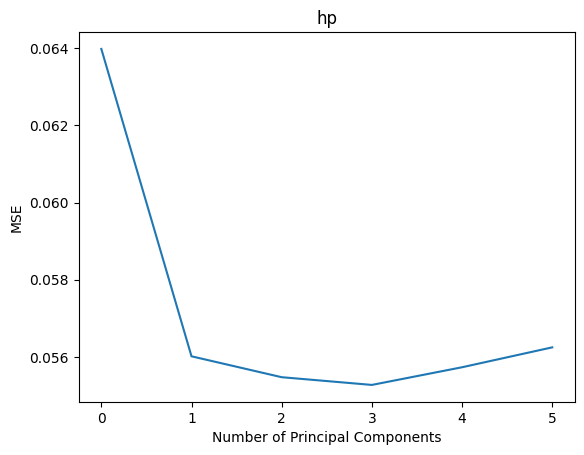

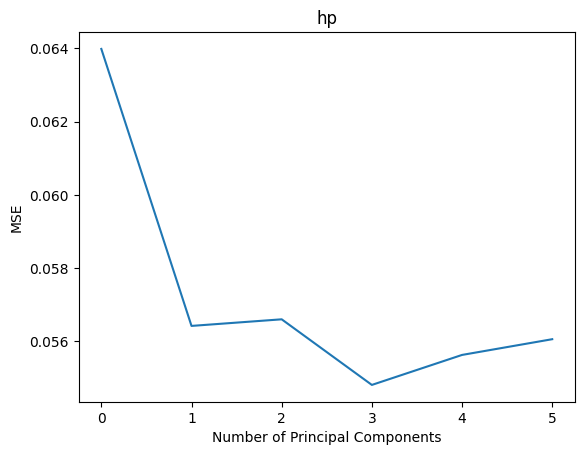

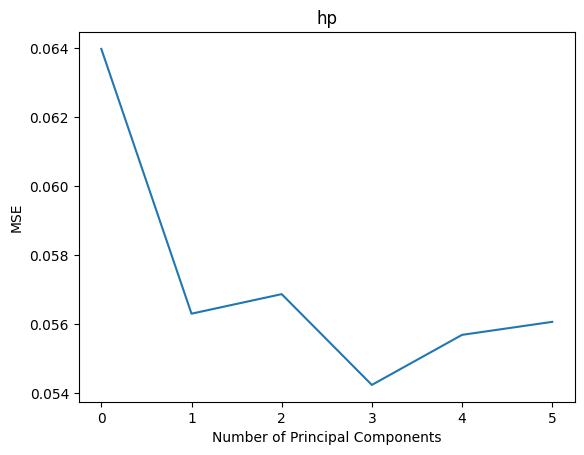

In [55]:
choose_pca(X=model_X_train,scaler=StandardScaler(),y=model_y_train,out=False)
choose_pca(X=model_X_train,scaler=MinMaxScaler(),y=model_y_train,out=False)
choose_pca(X=model_X_train,scaler=RobustScaler(),y=model_y_train,out=False)


In [56]:
n_comps = [1,3,3]
result_rows_2 = result_rows.copy()

for n,scale in zip(n_comps,scalers):
    pca_tmp = choose_pca(X=model_X_train,scaler=scale,y=model_y_train,plot =False)
    row = fit_pca(n,model_y_train,model_y_test,model_X_train,model_X_test,pca_tmp,scale)
    result_rows_2.append(row)

Looking at the plots, we can see that for the `StandardScaler()` we have an elbow at one component, for the `MinMaxScaler()` and the `RobustScaler()` three components seemed to be optimal. After these numbers, the MSE only decreases linearly or increases again. With `fit_pca()`, we fit a PCR model using these optimal numbers of principal components and evaluate the prediction result with the same two metrics we used for the other models.

In [57]:
results_df_2 = pd.DataFrame(result_rows_2,columns = ["scaler","model","r2","rmse"])

In [58]:
results_df_2

,scaler,model,r2,rmse
0,StandardScaler,SVR,-0.182435,0.184312
1,StandardScaler,Lasso,-0.139851,0.180962
2,StandardScaler,MLPRegressor,-1.727703,0.279938
3,StandardScaler,LinearRegression,-0.217410,0.187018
4,StandardScaler,RandomForestRegressor,-0.071431,0.175447
5,MinMaxScaler,SVR,-0.025814,0.171672
6,MinMaxScaler,Lasso,-0.139851,0.180962
7,MinMaxScaler,MLPRegressor,-0.155148,0.182172
8,MinMaxScaler,LinearRegression,-0.217410,0.187018
9,MinMaxScaler,RandomForestRegressor,-0.203681,0.185960


When inspecting these results one can see that none of the models, no matter the scaling technique used seemed to be able to explain the variability in the review scores for the locations in any satisfactory way. One might be able to find better models by introducing more data sets on additional subjects, however, it is quite difficult to find such data sets that are freely available to use and would make sense in the context of this analysis.

## Visualizations

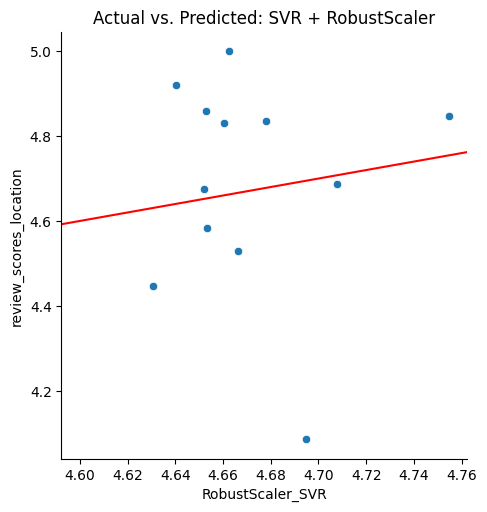

In [64]:
import matplotlib.axes as ax

sns.relplot(data=predict_df,x="RobustScaler_SVR",y = model_y_test)
plt.axline((4.6,4.6),slope=1,color="r")
plt.title("Actual vs. Predicted: SVR + RobustScaler")

plt.savefig("svr_robustscaler.png", bbox_inches="tight")
plt.show()

As we can see, the prediction is not very good, even when using our "best performing" model.

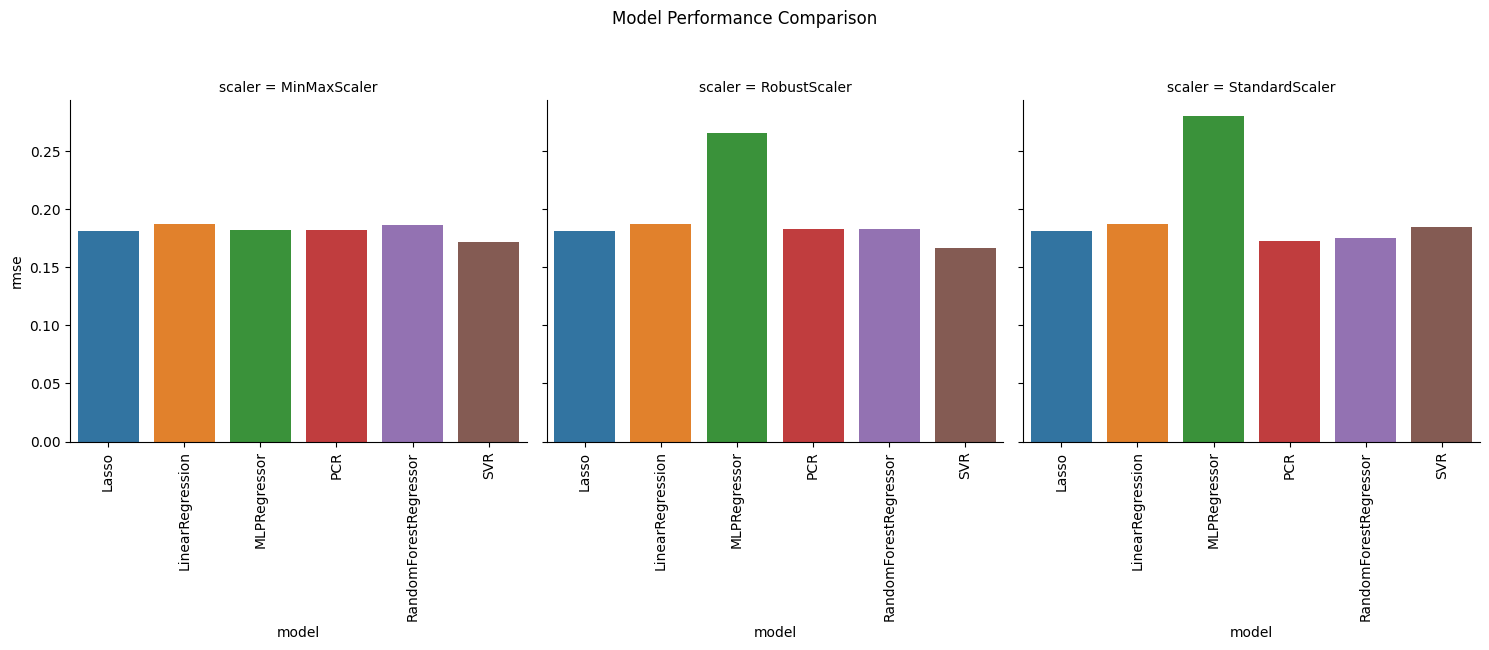

In [63]:
results_df_2["scaler"]=results_df_2["scaler"].astype("category")
results_df_2["model"]=results_df_2["model"].astype("category")
results_df.dtypes
g = sns.catplot(data=results_df_2, x='model', y='rmse', hue='model', col='scaler', kind='bar',dodge=False)
plt.suptitle("Model Performance Comparison")
g.fig.subplots_adjust(top=0.8)
for a in g.axes.flat:
    a.tick_params(axis='x', labelrotation=90)
plt.show()

As we can see, all the models perform very similarly across the board. An exception to this is the `MLPRegressor()` which performs even worse than the others for the `RobustScaler()` and the `StandardScaler()`. This is rather unsurprising, since this algorithm did not even converge when fitting it. Thus, we conclude that even nonlinear models did not find a meaningful connections of our input variables and the location rating.

## Potential Biases and Limitations

### Bias in the Data

Generally, ratings contain bias, as people tend to rate only when they feel strongly about something. This means in general highly positive and highly negative reviews are more often given than average reviews. As Airbnb offers a 30-day grace for hosts to respond to a bad review and therefore settle the matters with the guest, to remove the bad review, this causes a bias towards highly positive data. This can be seen, as most of the reviews are above 4.0.
The selected points of interests are prone to bias as well, as the tourist points of interest, are those that the city of Vienna provides, which might not include locations that would actually be interesting or contain not relevant locations as well.

### Limitations and Biases of the Analysis

The analysis puts each of the listings, transport stations and points of interests inside a grid cell to define proximity to the location. While this is accurate for locations in the center of a given grid cell, this is a simplification that ignores the proximity to locations in neighbouring grid cells for locations close to the border of the given grid cell.
Furthermore, the analysis is performed solely within the borders of Vienna, therefore locations outside of Vienna are completely omitted, which might penalize listings close to the border.

## New Data Science Tools and Techniques

Neither of us had performed a location analysis prior to the project, so a lot of insights were gained on how to perform such an analysis. Especially on how to do it in a computationally feasible way. We got more familiar with the `seaborn` package, which was only used for Exercise 1 so far and the obtained knowledge from back then was not sufficient to allow more sophisticated plots. Furthermore, `git` was used as a versioning system, which was new to most of the team members and took some time to adjust to. Last but not least, principal component analysis was new to some members of the team, which allowed a helpful knowledge exchange between the team members.

## Distribution of Work

The workload was divided equally between all the team members. Regular meetings were held to synchronize on the project status and tasks were parallelized where possible (e.g. writing reports, research concerning methodology,...) and for critical sections (e.g. model analysis, choosing approach,...) at least two members of the team worked together.